### Notebook to show evolution of submesoscale eddies for the 0.1 Pa case 
Make plan view plots of surface salinity, normalized relative vorticity, the frontogenesis function, and depth integrated numerical, physical, and total mixing. Work in progress.

In [1]:
#Packages
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
import pandas as pd
from matplotlib.ticker import AutoMinorLocator
from datetime import timedelta


In [2]:
path1 = '/d2/home/dylan/idealized_nummix/shelf_mpdata_uwind_zerop1_dt_30_60d_avg.nc'
path2 = '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_uwind_0_f_43N/shelf_dx_500_uwind_0_f_43N_open_avg.nc'
#0.1 Pa case
ds = xroms.open_netcdf(path2)
ds, grid = xroms.roms_dataset(ds)
# ds = ds.isel(ocean_time=slice(96,-1))
# ds['ocean_time'] = ds.ocean_time[:]+timedelta(days=4)
#Unforced case
# ds1 = xroms.open_netcdf(path2)
# ds1, grid1 = xroms.roms_dataset(ds1)
# ds1 = ds1.isel(ocean_time=slice(96,-1))

print(ds.ocean_time[0].values)
# print(ds1.ocean_time[0].values)

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


0001-01-01 00:30:00


In [11]:
def to_rho(var):
    if var.dims[-1] != 'xi_rho':
        var = grid.interp(var, 'X', to='center', boundary='extend')
    if var.dims[-2] != 'eta_rho':
        var = grid.interp(var, 'Y', to='center', boundary='extend')
    return var

def norm_fgf(ds,grid):
    qs = ds.salt # tracer 'q' (here salt) at the surface

    dqdx = to_rho(grid.derivative(qs, 'X')) # defined at rho-points
    dqdy = to_rho(grid.derivative(qs, 'Y'))

    us = ds.u # surface velocity field
    vs = ds.v

    dudx = grid.derivative(us, 'X', boundary='extend')
    dvdy = grid.derivative(vs, 'Y', boundary='extend')
    dudy = to_rho(grid.derivative(us, 'Y', boundary='extend'))
    dvdx = to_rho(grid.derivative(vs, 'X', boundary='extend'))

    Dgradq_i = - dudx*dqdx - dvdx*dqdy
    Dgradq_j = - dudy*dqdx - dvdy*dqdy

    # The frontogenesis function
    Ddelq2 = (dqdx*Dgradq_i + dqdy*Dgradq_j)
    Ddelq2.name = 'Frontogenesis function'

    # Density gradients squared
    gradq2 = dqdx**2 + dqdy**2
    gradq2.name = r'$(\nabla q)^2$'

    # Normalized frontogenesis function
    nDGQ2 = Ddelq2 / (gradq2 * ds.f)
    nDGQ2.name = r'Normalized Frontogenesis Function'
    return nDGQ2
nDGQ2 = norm_fgf(ds,grid)
# nDGQ2_1 = norm_fgf(ds1,grid1)

In [12]:
def velgrad(ds,grid):
    us = ds.u # surface velocity field
    vs = ds.v

    dudx = grid.derivative(us, 'X', boundary='extend')
    dvdy = grid.derivative(vs, 'Y', boundary='extend')
    dudy = to_rho(grid.derivative(us, 'Y', boundary='extend'))
    dvdx = to_rho(grid.derivative(vs, 'X', boundary='extend'))
    # Vorticity:  v_x - u_y
    zeta = (dvdx - dudy)/ds.f
    # zeta.coords['lon_rho'] = ds.coords['lon_rho']
    # zeta.coords['lat_rho'] = ds.coords['lat_rho']
    zeta.name = 'Normalized vorticity'

    # Divergence: u_x + v_y
    delta = (dudx + dvdy)/ds.f
    # delta.coords['lon_rho'] = ds.coords['lon_rho']
    # delta.coords['lat_rho'] = ds.coords['lat_rho']
    delta.name = 'Normalized divergence'

    # Major axis of deformation
    alpha = ( np.sqrt( (dudx-dvdy)**2 + (dvdx+dudy)**2 ) )/ds.f
    # alpha.coords['lon_rho'] = ds.coords['lon_rho']
    # alpha.coords['lat_rho'] = ds.coords['lat_rho']
    alpha.name = 'Normalized strain'

    # Principle deformation components
    lminor = 0.5 * (delta - alpha)
    # lminor.coords['lon_rho'] = ds.coords['lon_rho']
    # lminor.coords['lat_rho'] = ds.coords['lat_rho']
    lminor.name = 'lambda minor'

    lmajor = 0.5 * (delta + alpha)
    # lmajor.coords['lon_rho'] = ds.coords['lon_rho']
    # lmajor.coords['lat_rho'] = ds.coords['lat_rho']
    lmajor.name = 'lambda major'
    
    return zeta,delta,alpha,lminor,lmajor

zeta,delta,alpha,lminor,lmajor = velgrad(ds,grid)
# zeta1,delta1,alpha1,lminor1,lmajor1= velgrad(ds1,grid1)

In [13]:
def surface_saltgradmag(ds, grid):
    '''
Calculates the surface horizontal salinity gradient magnitude normalized by 
the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
sgradmag: horizontal salinity gradient magnitude on the psi points

    '''
    s = ds.salt.isel(s_rho=-1)

    dsdx = grid.derivative(s, 'X', boundary = 'extend')
    dsdx_psi = xroms.to_rho(dsdx, grid)
    dsdy = grid.derivative(s, 'Y', boundary = 'extend')
    dsdy_psi = xroms.to_rho(dsdy, grid)
    
    sgradmag = (dsdx_psi**2+dsdy_psi**2)**(1/2)
    
    return sgradmag

sgradmag = surface_saltgradmag(ds, grid)
# sgradmag1 = surface_saltgradmag(ds1, grid1)

In [14]:
print(ds.ocean_time[180].values)
print(ds.ocean_time[240].values)
print(ds.ocean_time[300].values)
print(ds.ocean_time[360].values)

0001-01-08 12:30:00
0001-01-11 00:30:00
0001-01-13 12:30:00
0001-01-16 00:30:00


/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Text(2, 87, '(p)')

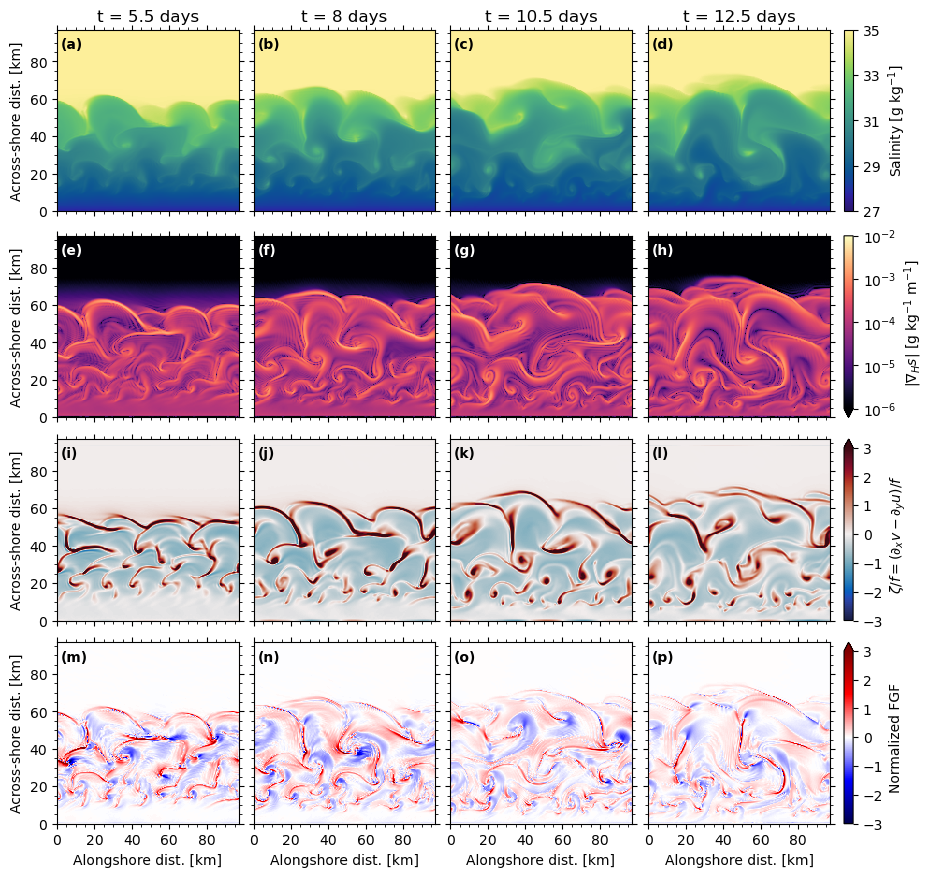

In [16]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(4,4, figsize = ((7/2)*2.63,8.66), constrained_layout = True)

#salt
xrho = (ds.x_rho/1000).values
yrho = (ds.y_rho/1000).values

mappable1 = ax[0,0].pcolormesh(xrho, yrho, ds.salt[180,-1].values, cmap = cmo.haline, vmin = 27, vmax = 35)
mappable2 = ax[0,1].pcolormesh(xrho, yrho, ds.salt[240,-1].values, cmap = cmo.haline, vmin = 27, vmax = 35)
mappable3 = ax[0,2].pcolormesh(xrho, yrho, ds.salt[300,-1].values, cmap = cmo.haline, vmin = 27, vmax = 35)
mappable4 = ax[0,3].pcolormesh(xrho, yrho, ds.salt[360,-1].values, cmap = cmo.haline, vmin = 27, vmax = 35)

cbar = fig.colorbar(mappable4, ax = ax[0,3], label = '', ticks = [27, 29, 31, 33, 35],)
cbar.ax.set_ylabel(r'Salinity [g kg$^{-1}$]')

sfill = sgradmag[180].where(sgradmag[180]>1e-6)
sfill0 = sfill.fillna(value=1e-6)
sfill1 = sgradmag[240].where(sgradmag[240]>1e-6)
sfill01 = sfill1.fillna(value=1e-6)
sfill2 = sgradmag[300].where(sgradmag[300]>1e-6)
sfill02 = sfill2.fillna(value=1e-6)
sfill3 = sgradmag[360].where(sgradmag[360]>1e-6)
sfill03 = sfill3.fillna(value=1e-6)

mappable5 = ax[1,0].pcolormesh(xrho, yrho, np.log10(sfill0), cmap = plt.get_cmap('magma'), vmin = -6, vmax = -2)
mappable6 = ax[1,1].pcolormesh(xrho, yrho, np.log10(sfill01), cmap = plt.get_cmap('magma'), vmin = -6, vmax = -2)
mappable7 = ax[1,2].pcolormesh(xrho, yrho, np.log10(sfill02), cmap = plt.get_cmap('magma'), vmin = -6, vmax = -2)
mappable8 = ax[1,3].pcolormesh(xrho, yrho, np.log10(sfill03), cmap = plt.get_cmap('magma'), vmin = -6, vmax = -2)
cbar = fig.colorbar(mappable8, ax = ax[1,3], label = '', extend = 'min', format=tick.FormatStrFormatter('$10^{%.0f}$'))
cbar.ax.set_ylabel(r'$|\nabla_H s|$ [g kg$^{-1}$ m$^{-1}$]')

mappable9 = ax[2,0].pcolormesh(xrho, yrho, zeta[180-48,-1], cmap = plt.get_cmap('cmo.balance'), vmin = -3, vmax = 3)
mappable10 = ax[2,1].pcolormesh(xrho, yrho, zeta[240-48,-1], cmap = plt.get_cmap('cmo.balance'), vmin = -3, vmax = 3)
mappable11 = ax[2,2].pcolormesh(xrho, yrho, zeta[300-48,-1], cmap = plt.get_cmap('cmo.balance'), vmin = -3, vmax = 3)
mappable12 = ax[2,3].pcolormesh(xrho, yrho, zeta[360-48,-1], cmap = plt.get_cmap('cmo.balance'), vmin = -3, vmax = 3)
cbar = fig.colorbar(mappable12, ax = ax[2,3], label = '', extend = 'max', ticks = [-3,-2,-1,0,1,2,3])
cbar.ax.set_ylabel(r'$\zeta/f=(\partial_x v - \partial_y u)/f$')

mappable13 = ax[3,0].pcolormesh(xrho, yrho, nDGQ2[180,-1], cmap = plt.get_cmap('seismic'), vmin = -3, vmax = 3)
mappable14 = ax[3,1].pcolormesh(xrho, yrho, nDGQ2[240,-1], cmap = plt.get_cmap('seismic'), vmin = -3, vmax = 3)
mappable15 = ax[3,2].pcolormesh(xrho, yrho, nDGQ2[300,-1], cmap = plt.get_cmap('seismic'), vmin = -3, vmax = 3)
mappable16 = ax[3,3].pcolormesh(xrho, yrho, nDGQ2[360,-1], cmap = plt.get_cmap('seismic'), vmin = -3, vmax = 3)
cbar = fig.colorbar(mappable16, ax = ax[3,3], label = '', extend = 'max', ticks = [-3,-2,-1,0,1,2,3])
cbar.ax.set_ylabel(r'Normalized FGF')

for i in range(4):
    for j in range(4):
        ax[i,j].set(xlim=[0,97], ylim=[0,97])
        ax[i,0].set_ylabel('Across-shore dist. [km]')
        ax[3,j].set_xlabel('Alongshore dist. [km]')
        ax[i,1].set_yticklabels([])
        ax[i,2].set_yticklabels([])
        ax[i,3].set_yticklabels([])
        ax[i,j].set_xticks(np.arange(0,100,20))
        ax[i,j].minorticks_on()
        ax[i,j].tick_params(which = 'both',bottom=True, top=True, left=True, right=True)
        ax[i,j].tick_params(which = 'both',labelbottom=True, labeltop=False, labelleft=True, labelright=False)
        ax[i,j].set_aspect('equal')

for i in range(3):
    for j in range(4):
        ax[i,j].set_xticklabels([])

ax[0,0].set_title(r't = 5.5 days')
ax[0,1].set_title(r't = 8 days')
ax[0,2].set_title(r't = 10.5 days')
ax[0,3].set_title(r't = 12.5 days')

ax[0,0].text(2,87, '(a)', fontweight = 'semibold')
ax[0,1].text(2,87, '(b)', fontweight = 'semibold')
ax[0,2].text(2,87, '(c)', fontweight = 'semibold')
ax[0,3].text(2,87, '(d)', fontweight = 'semibold')
ax[1,0].text(2,87, '(e)', fontweight = 'semibold', color = 'white')
ax[1,1].text(2,87, '(f)', fontweight = 'semibold', color = 'white')
ax[1,2].text(2,87, '(g)', fontweight = 'semibold', color = 'white')
ax[1,3].text(2,87, '(h)', fontweight = 'semibold', color = 'white')
ax[2,0].text(2,87, '(i)', fontweight = 'semibold')
ax[2,1].text(2,87, '(j)', fontweight = 'semibold')
ax[2,2].text(2,87, '(k)', fontweight = 'semibold')
ax[2,3].text(2,87, '(l)', fontweight = 'semibold')
ax[3,0].text(2,87, '(m)', fontweight = 'semibold')
ax[3,1].text(2,87, '(n)', fontweight = 'semibold')
ax[3,2].text(2,87, '(o)', fontweight = 'semibold')
ax[3,3].text(2,87, '(p)', fontweight = 'semibold')
# plt.savefig('surface_properties_fronts.jpg', dpi = 600, bbox_inches='tight')

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Text(2, 87, '(p)')

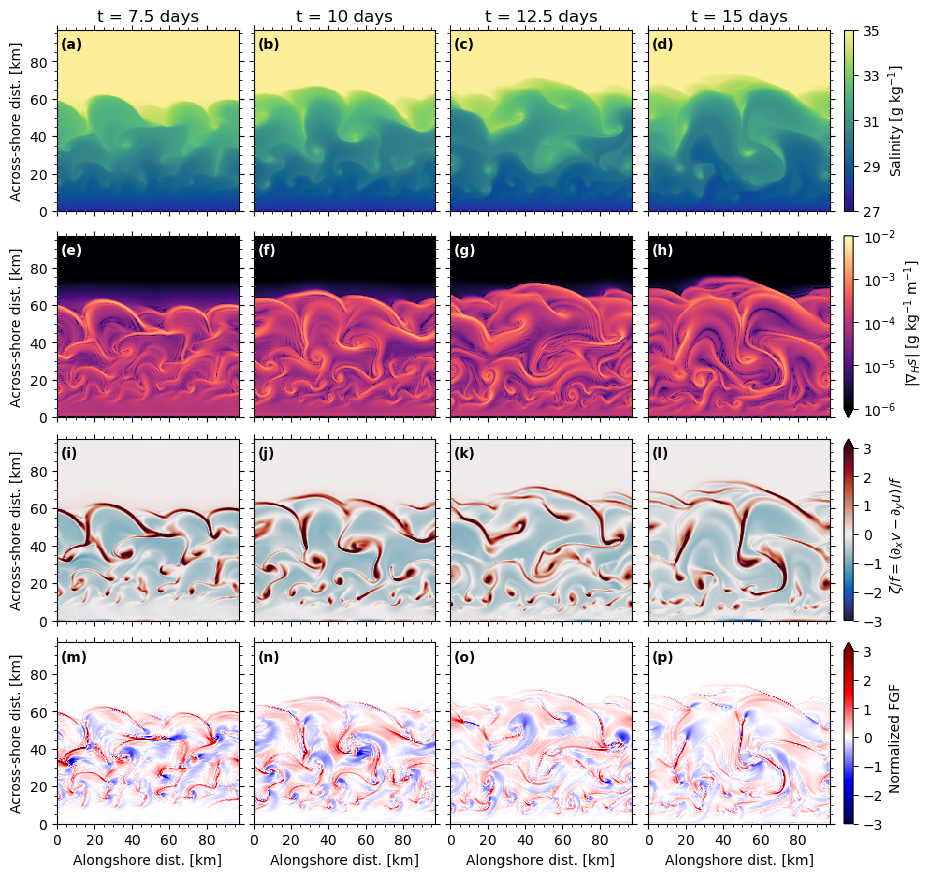

In [15]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(4,4, figsize = ((7/2)*2.63,8.66), constrained_layout = True)

#salt
xrho = (ds.x_rho/1000).values
yrho = (ds.y_rho/1000).values

mappable1 = ax[0,0].pcolormesh(xrho, yrho, ds.salt[180,-1].values, cmap = cmo.haline, vmin = 27, vmax = 35)
mappable2 = ax[0,1].pcolormesh(xrho, yrho, ds.salt[240,-1].values, cmap = cmo.haline, vmin = 27, vmax = 35)
mappable3 = ax[0,2].pcolormesh(xrho, yrho, ds.salt[300,-1].values, cmap = cmo.haline, vmin = 27, vmax = 35)
mappable4 = ax[0,3].pcolormesh(xrho, yrho, ds.salt[360,-1].values, cmap = cmo.haline, vmin = 27, vmax = 35)

cbar = fig.colorbar(mappable4, ax = ax[0,3], label = '', ticks = [27, 29, 31, 33, 35],)
cbar.ax.set_ylabel(r'Salinity [g kg$^{-1}$]')

sfill = sgradmag[180].where(sgradmag[180]>1e-6)
sfill0 = sfill.fillna(value=1e-6)
sfill1 = sgradmag[240].where(sgradmag[240]>1e-6)
sfill01 = sfill1.fillna(value=1e-6)
sfill2 = sgradmag[300].where(sgradmag[300]>1e-6)
sfill02 = sfill2.fillna(value=1e-6)
sfill3 = sgradmag[360].where(sgradmag[360]>1e-6)
sfill03 = sfill3.fillna(value=1e-6)

mappable5 = ax[1,0].pcolormesh(xrho, yrho, np.log10(sfill0), cmap = plt.get_cmap('magma'), vmin = -6, vmax = -2)
mappable6 = ax[1,1].pcolormesh(xrho, yrho, np.log10(sfill01), cmap = plt.get_cmap('magma'), vmin = -6, vmax = -2)
mappable7 = ax[1,2].pcolormesh(xrho, yrho, np.log10(sfill02), cmap = plt.get_cmap('magma'), vmin = -6, vmax = -2)
mappable8 = ax[1,3].pcolormesh(xrho, yrho, np.log10(sfill03), cmap = plt.get_cmap('magma'), vmin = -6, vmax = -2)
cbar = fig.colorbar(mappable8, ax = ax[1,3], label = '', extend = 'min', format=tick.FormatStrFormatter('$10^{%.0f}$'))
cbar.ax.set_ylabel(r'$|\nabla_H s|$ [g kg$^{-1}$ m$^{-1}$]')

mappable9 = ax[2,0].pcolormesh(xrho, yrho, zeta[180,-1], cmap = plt.get_cmap('cmo.balance'), vmin = -3, vmax = 3)
mappable10 = ax[2,1].pcolormesh(xrho, yrho, zeta[240,-1], cmap = plt.get_cmap('cmo.balance'), vmin = -3, vmax = 3)
mappable11 = ax[2,2].pcolormesh(xrho, yrho, zeta[300,-1], cmap = plt.get_cmap('cmo.balance'), vmin = -3, vmax = 3)
mappable12 = ax[2,3].pcolormesh(xrho, yrho, zeta[360,-1], cmap = plt.get_cmap('cmo.balance'), vmin = -3, vmax = 3)
cbar = fig.colorbar(mappable12, ax = ax[2,3], label = '', extend = 'max', ticks = [-3,-2,-1,0,1,2,3])
cbar.ax.set_ylabel(r'$\zeta/f=(\partial_x v - \partial_y u)/f$')

mappable13 = ax[3,0].pcolormesh(xrho, yrho, nDGQ2[180,-1], cmap = plt.get_cmap('seismic'), vmin = -3, vmax = 3)
mappable14 = ax[3,1].pcolormesh(xrho, yrho, nDGQ2[240,-1], cmap = plt.get_cmap('seismic'), vmin = -3, vmax = 3)
mappable15 = ax[3,2].pcolormesh(xrho, yrho, nDGQ2[300,-1], cmap = plt.get_cmap('seismic'), vmin = -3, vmax = 3)
mappable16 = ax[3,3].pcolormesh(xrho, yrho, nDGQ2[360,-1], cmap = plt.get_cmap('seismic'), vmin = -3, vmax = 3)
cbar = fig.colorbar(mappable16, ax = ax[3,3], label = '', extend = 'max', ticks = [-3,-2,-1,0,1,2,3])
cbar.ax.set_ylabel(r'Normalized FGF')

for i in range(4):
    for j in range(4):
        ax[i,j].set(xlim=[0,97], ylim=[0,97])
        ax[i,0].set_ylabel('Across-shore dist. [km]')
        ax[3,j].set_xlabel('Alongshore dist. [km]')
        ax[i,1].set_yticklabels([])
        ax[i,2].set_yticklabels([])
        ax[i,3].set_yticklabels([])
        ax[i,j].set_xticks(np.arange(0,100,20))
        ax[i,j].minorticks_on()
        ax[i,j].tick_params(which = 'both',bottom=True, top=True, left=True, right=True)
        ax[i,j].tick_params(which = 'both',labelbottom=True, labeltop=False, labelleft=True, labelright=False)
        ax[i,j].set_aspect('equal')

for i in range(3):
    for j in range(4):
        ax[i,j].set_xticklabels([])

ax[0,0].set_title(r't = 7.5 days')
ax[0,1].set_title(r't = 10 days')
ax[0,2].set_title(r't = 12.5 days')
ax[0,3].set_title(r't = 15 days')

ax[0,0].text(2,87, '(a)', fontweight = 'semibold')
ax[0,1].text(2,87, '(b)', fontweight = 'semibold')
ax[0,2].text(2,87, '(c)', fontweight = 'semibold')
ax[0,3].text(2,87, '(d)', fontweight = 'semibold')
ax[1,0].text(2,87, '(e)', fontweight = 'semibold', color = 'white')
ax[1,1].text(2,87, '(f)', fontweight = 'semibold', color = 'white')
ax[1,2].text(2,87, '(g)', fontweight = 'semibold', color = 'white')
ax[1,3].text(2,87, '(h)', fontweight = 'semibold', color = 'white')
ax[2,0].text(2,87, '(i)', fontweight = 'semibold')
ax[2,1].text(2,87, '(j)', fontweight = 'semibold')
ax[2,2].text(2,87, '(k)', fontweight = 'semibold')
ax[2,3].text(2,87, '(l)', fontweight = 'semibold')
ax[3,0].text(2,87, '(m)', fontweight = 'semibold')
ax[3,1].text(2,87, '(n)', fontweight = 'semibold')
ax[3,2].text(2,87, '(o)', fontweight = 'semibold')
ax[3,3].text(2,87, '(p)', fontweight = 'semibold')
# plt.savefig('surface_properties_fronts.jpg', dpi = 600, bbox_inches='tight')

### Create a 2X2 panel of the base case to show: vorticity, salinity gradient magnitude, divergence, and nFGF

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


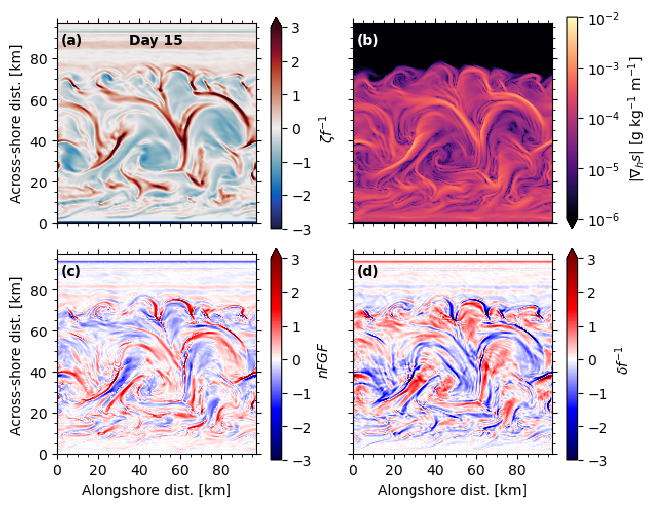

In [59]:
fig, ax = plt.subplots(2,2, figsize = (6.47,5), constrained_layout = True)

#Vorticity
m = ax[0,0].pcolormesh(xrho, yrho, zeta[360,-1], cmap = plt.get_cmap('cmo.balance'), vmin = -3, vmax = 3)
cbar = fig.colorbar(m, ax = ax[0,0], label = '', extend = 'max', ticks = [-3,-2,-1,0,1,2,3])
cbar.ax.set_ylabel(r'$\zeta f^{-1}$')

sfill3 = sgradmag[360].where(sgradmag[360]>1e-6)
sfill03 = sfill3.fillna(value=1e-6)

m1= ax[0,1].pcolormesh(xrho, yrho, np.log10(sfill03), cmap = plt.get_cmap('magma'), vmin = -6, vmax = -2)
cbar = fig.colorbar(m1, ax = ax[0,1], label = '', extend = 'min', format=tick.FormatStrFormatter('$10^{%.0f}$'))
cbar.ax.set_ylabel(r'$|\nabla_h s|$ [g kg$^{-1}$ m$^{-1}$]')

m2= ax[1,0].pcolormesh(xrho, yrho, nDGQ2[360,-1], cmap = plt.get_cmap('seismic'), vmin = -3, vmax = 3)
cbar = fig.colorbar(m2, ax = ax[1,0], label = '', extend = 'max', ticks = [-3,-2,-1,0,1,2,3])
cbar.ax.set_ylabel(r'$nFGF$')

m3 = ax[1,1].pcolormesh(xrho, yrho, delta[360,-1], cmap = plt.get_cmap('seismic'), vmin = -3, vmax = 3)
cbar = fig.colorbar(m3, ax = ax[1,1], label = '', extend = 'max', ticks = [-3,-2,-1,0,1,2,3])
cbar.ax.set_ylabel(r'$\delta f^{-1}$')

for i in range(2):
    for j in range(2):
        ax[i,j].set(xlim=[0,97], ylim=[0,97])
        ax[i,0].set_ylabel('Across-shore dist. [km]')
        ax[-1,j].set_xlabel('Alongshore dist. [km]')
        ax[i,1].set_yticklabels([])
        ax[i,j].set_xticks(np.arange(0,100,20))
        ax[i,j].set_yticks(np.arange(0,100,20))
        ax[i,j].minorticks_on()
        ax[i,j].tick_params(which = 'both',bottom=True, top=True, left=True, right=True)
        ax[i,j].tick_params(which = 'both',labelbottom=True, labeltop=False, labelleft=True, labelright=False)
        ax[i,j].set_aspect('equal')

for i in range(1):
    for j in range(2):
        ax[i,j].set_xticklabels([])

ax[0,0].text(2,87, '(a)', fontweight = 'semibold')
ax[0,0].text(35,87, 'Day 15', fontweight = 'semibold')
ax[0,1].text(2,87, '(b)', fontweight = 'semibold', color = 'white')
ax[1,0].text(2,87, '(c)', fontweight = 'semibold')
ax[1,1].text(2,87, '(d)', fontweight = 'semibold')

fig.canvas.draw()
plt.savefig('surface_properties_day15.jpg', dpi = 600, bbox_inches='tight')

#### Now do a linear regression 

In [135]:
def polyfit(x, y, degree, weights):
    '''
Fits x and y to an n degree polynomial, allows for weights to be added
  and returns the coefficients: i.e. y = ax + b and the coefficient of 
  determination based on weighted regrression. 
  
Inputs: 
------
x: x variable for WLS
y: desired y variable for WLS
degree: fit of polynomial (1 for linear)
weights: Vector of weights

Outputs:
------
results: Contains slope and y-intercept of regression
r2: Weighted coefficient of determination

Notes: 
------
r^2 = 1 - (SSR/SST), where
SSR = sum(w_i(y_i - y^hat)^2)
SST = sum(w_i(y_i - ybar)^2),
w_i = weights, i.e., dV
y_i = observed value of y
y^hat = predicted y value by WLS regression
ybar = weighted average value of observed y...
ybar = sum(w_i*y_i)/sum(w_i)
  
Source: Willett and Singer (1988) Another Cautionary Note...
    '''    
    results = {}

    coeffs = np.polyfit(x, y, degree, w = weights)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()
    
    #Predicted values for r^2
    p = np.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)
    
    #Compute r^2 using 
    ss_residual = sum(weights*(y-yhat)**2)
    ss_total = sum(weights*(y-np.average(y, weights = weights))**2)
    r2 = (1-(ss_residual/ss_total))
    
    return results, r2

In [136]:
dstack = d.stack(z = ['ocean_time', 'eta_rho', 'xi_rho']).values
nstack = n.stack(z = ['ocean_time', 'eta_rho', 'xi_rho']).values

In [137]:
y = nstack
x = dstack
w = np.ones(len(x))
deg = 1 #Linear fit

results_weighted, r2 = polyfit(x, y, deg, w) #weighted
print(results_weighted, r2)

{'polynomial': [-0.7428533558571259, 0.05429314913158445]} 0.7078765677883466


In [138]:
#Sort 
x_sort = np.sort(x)

#Create a vector of values for numerical mixing equal to the length of the stacked salinity gradient
xwhole = np.linspace(x_sort[0], x_sort[-1], 1000)
y_pred_weighted = results_weighted['polynomial'][0]*xwhole+results_weighted['polynomial'][1]

Text(0.5, 1.0, 'Base case: Days 7.5-15')

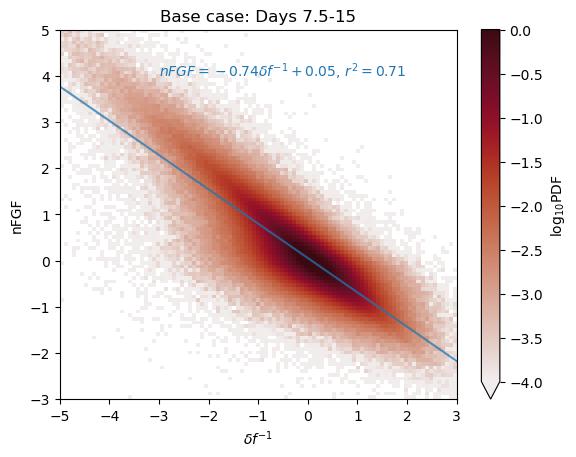

In [142]:
np.log10(dn_hist.T).plot(cmap = cmo.amp, vmin = -4, vmax = 0, 
                         cbar_kwargs = {'label':r'log$_{10}$PDF',
                                        'extend':'min'})

plt.plot(xwhole, y_pred_weighted, alpha = 0.75)
plt.text(-3,4, r'$nFGF = -0.74\delta f^{-1}+0.05, \, r^2 = 0.71$', color = 'tab:blue')
plt.ylabel('nFGF')
plt.xlabel(r'$\delta f^{-1}$')
plt.title('Base case: Days 7.5-15')

In [143]:
dbins = np.linspace(-3,3,100)
nbins = np.linspace(-3,3,100)
dn_hist = histogram(d,n, bins = [dbins, nbins], dim = ['ocean_time','xi_rho','eta_rho'], density = True).load()

dstack = d.stack(z = ['ocean_time', 'eta_rho', 'xi_rho']).values
nstack = n.stack(z = ['ocean_time', 'eta_rho', 'xi_rho']).values

y = nstack
x = dstack
w = np.ones(len(x))
deg = 1 #Linear fit

results_weighted, r2 = polyfit(x, y, deg, w) #weighted
print(results_weighted, r2)

#Sort 
x_sort = np.sort(x)

#Create a vector of values for numerical mixing equal to the length of the stacked salinity gradient
xwhole = np.linspace(x_sort[0], x_sort[-1], 1000)
y_pred_weighted = results_weighted['polynomial'][0]*xwhole+results_weighted['polynomial'][1]

{'polynomial': [-0.7428533558571259, 0.05429314913158445]} 0.7078765677883466


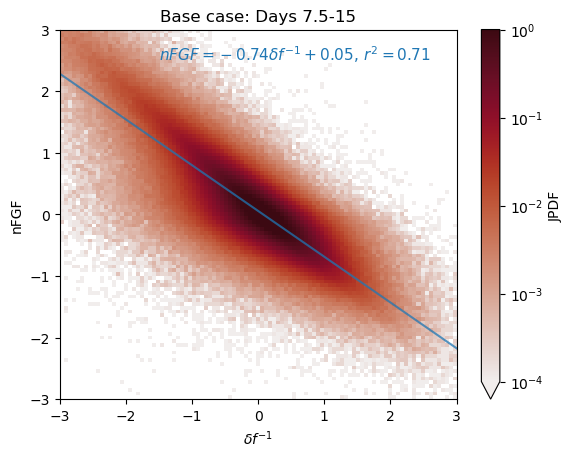

In [165]:
np.log10(dn_hist.T).plot(cmap = cmo.amp, vmin = -4, vmax = 0, 
                         cbar_kwargs = {'label':r'JPDF',
                                        'extend':'min',
                                        'ticks':np.arange(-4,1,1),
                                        'format':tick.FormatStrFormatter('$10^{%d}$')})

plt.plot(xwhole, y_pred_weighted, alpha = 0.75)
plt.text(-1.5,2.5, r'$nFGF = -0.74\delta f^{-1}+0.05, \, r^2 = 0.71$', 
         color = 'tab:blue', fontsize = 11, fontweight = 'bold')
plt.ylabel('nFGF')
plt.xlabel(r'$\delta f^{-1}$')
plt.title('Base case: Days 7.5-15')
plt.savefig('delta_nfgf_JPDF', dpi=300, bbox_inches = 'tight')

### We could continue to refine this by further removing water pile up near the coastal wall but this is unecessary 